# Developing Customizable, Interactive Sankey Plots for US RCC Dataset

## Imports

In [7]:
SEED = 42

import tensorflow as tf
import pandas as pd 
import numpy as np
np.random.seed(SEED)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import plotly.graph_objects as go
import plotly.express as px
from time import time
import json
import warnings
%matplotlib inline

In [8]:
# Accelerate SKL for Intel
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load dataset

<Axes: >

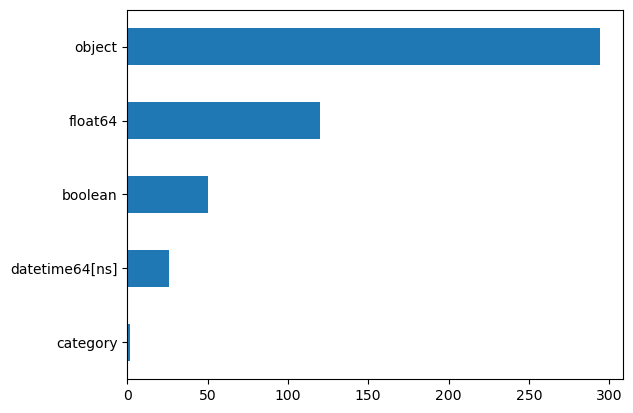

In [9]:
rcc = pd.read_pickle('../Data Sources/Cleaned/US_RCC_Database_CLEANED.pkl')
# Check to make sure dtypes persisted
rcc.dtypes.value_counts().sort_values().plot(kind = 'barh')

## TODO: Visualization w/ Alluvial Diagrams

Ultimate goal is to forecast treatment paths at an individual level using a NN. Here, we will demonstrate what this looks like at the population level. 
* Begin with anastomotic leak as end goal
* Break up path along stages of treatment
* We can take a stepwise regression/decision tree approach to add the most 'descriminant' features one at a time. Couple w/ statistical tests and display significance on chart
* Need to handle different dtypes
    * Treat num vals as parallel sets
    * NaNs as own cat
    * Might need to break up chemo regimens along y-axis

### Reproduce Ali et. al. (2024) findings on OFP -> Leak

Num samples: 825

Independent Variable:
Omental Flap to Pelvis
no     722
yes    103
Name: count, dtype: int64

Dependent Variable:
Anastomotic Leak
no     446
NaN    338
yes     41
Name: count, dtype: int64

Summary of selected demographic stats:


array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='Height (cm)', ylabel='Age'>,
        <Axes: xlabel='Weight (kg)', ylabel='Age'>,
        <Axes: xlabel='BMI', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='Height (cm)'>,
        <Axes: xlabel='Height (cm)', ylabel='Height (cm)'>,
        <Axes: xlabel='Weight (kg)', ylabel='Height (cm)'>,
        <Axes: xlabel='BMI', ylabel='Height (cm)'>],
       [<Axes: xlabel='Age', ylabel='Weight (kg)'>,
        <Axes: xlabel='Height (cm)', ylabel='Weight (kg)'>,
        <Axes: xlabel='Weight (kg)', ylabel='Weight (kg)'>,
        <Axes: xlabel='BMI', ylabel='Weight (kg)'>],
       [<Axes: xlabel='Age', ylabel='BMI'>,
        <Axes: xlabel='Height (cm)', ylabel='BMI'>,
        <Axes: xlabel='Weight (kg)', ylabel='BMI'>,
        <Axes: xlabel='BMI', ylabel='BMI'>]], dtype=object)

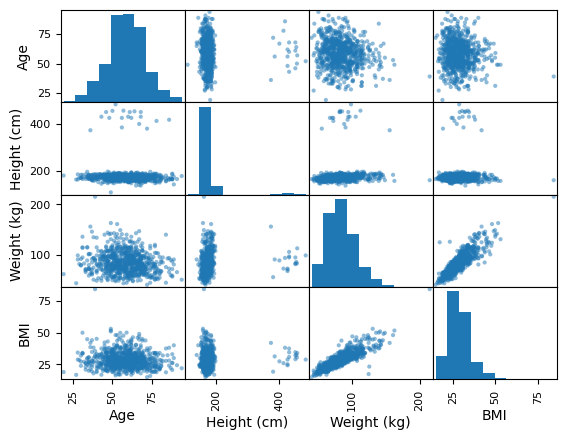

In [10]:
# Include patients w/ LAR and non-missing OFP data
leak_mvp = rcc[(rcc['Type of Operation of Rectal Tumor'] == 'lar') & rcc['Omental Flap to Pelvis'].notna()]

# Generate some summary stats
print("Num samples:", len(leak_mvp))
print("\nIndependent Variable:")
print(leak_mvp['Omental Flap to Pelvis'].value_counts(dropna=False))
print("\nDependent Variable:")
print(leak_mvp['Anastomotic Leak'].value_counts(dropna=False))
print("\nSummary of selected demographic stats:")
demo_feats = [  'Gender',
                'Age',
                'Race',
                'Height (cm)',
                'Weight (kg)',
                'BMI',
                'Health Insurance',
                'ASA Class',
                'Functional Status',
                'Family history of CRC',
                'Date of Diagnosis',
                'Primary v. Recurrence',
                'Omental Flap to Pelvis',
                'Anastomotic Leak']
pd.plotting.scatter_matrix(leak_mvp[demo_feats])

In [11]:
import sys
sys.path.insert(0,"..")

from BetterSankey.better_sankey import SankeyPlot

In [12]:
feats = ['Gender', 'Functional Status', 'Family history of CRC', 'Diabetes', 'Sphincter Preservation', 'Readmission', 'Minor vs Major Complication', 'Adjuvant Chemotherapy', 'Death']
response = 'Death'

plot_data = rcc[feats].copy()
print(len(plot_data))
plot_data = plot_data.dropna().reset_index(drop=True)
len(plot_data)

1788


937

In [19]:
feats = ['Gender', 'Diabetes', 'Functional Status', 'Anastomotic Leak']
response = 'Anastomotic Leak'
plot_data = leak_mvp.copy()
plot_data['Anastomotic Leak'] = plot_data['Anastomotic Leak'].fillna('no')
sankey = SankeyPlot()
sankey.build_sankey(plot_data, feats, response, significance=False,
                    branch_feats=['Diabetes'],
                    color_json='../Data Sources/Cleaned/feature_colors.json',
                    link_swatch=px.colors.qualitative.Pastel1_r,
                    hover_swatch=px.colors.qualitative.Set1_r)

## Anastomotic Leak Analysis

In [8]:
feats = ['Gender', 'Bowel Obstruction', 'Diabetes', 'Neoadjuvant Chemoradiation', 'Operative Approach', 'Omental Flap to Pelvis', 'Anastomotic Leak']
response = 'Anastomotic Leak'

plot_data = leak_mvp.copy()
plot_data['Anastomotic Leak'] = plot_data['Anastomotic Leak'].fillna('no')
sankey = SankeyPlot()
sankey.build_sankey(plot_data, feats, response, 
                    color_json='../Data Sources/Cleaned/feature_colors.json',
                    link_swatch = px.colors.qualitative.Pastel1_r,
                    hover_swatch = px.colors.qualitative.Set1_r)

### Improvements
* Build ML model (MLR, SVM, DT) with features and report result
* $\chi^2$ test for proportions for each feature w.r.t. final output, next feature
* Handle continuous variables in a parallel plot-eske manner
* Selecting a feature filters for only that value

## Sequential Feature Selection
Proof of concept using only discrete features to visualize with Sankey

### Simple Preprocessing
1. Omit numeric dtypes, cast all others to obj
1. Take out labels, impute missing w/ 'no'
1. Create transformation pipeline:
1. For obj w/ <= 3 unique vals, one-hot enc
1. For all other obj, target encode

In [9]:
leak = leak_mvp.select_dtypes(exclude = ['float64', 'datetime64[ns]'])
leak = leak.astype('category')
leak = leak.drop(['Database ID', 'COMMENTS'], axis=1)

In [10]:
labels = leak['Anastomotic Leak'].copy().fillna('no')
leak = leak.drop('Anastomotic Leak', axis=1)
labels = pd.to_numeric(labels.replace({'yes': 1.0, 'no': 0.0}))

Drop features that are too powerful predictors of a leak
* 'Intervention Required'
* Anything with 'leak'

TODO Consider:
* Cols after 'Aanastomotic Leak' (esp. Type of Intervention)

In [11]:
# Drop 'Intervention Required', predictions were made solely on this value
leak = leak.drop(['Intervention Required'], axis=1)
leak = leak.drop(['Type of Intervention'], axis=1)
leak = leak.drop(list(leak.filter(regex = 'Leak')), axis=1)

In [12]:
sparse_attribs = [col for col in leak.columns.to_list() if leak[col].nunique(dropna=False) < 4]
dense_attribs = leak.drop(sparse_attribs, axis=1).columns.to_list()

In [13]:
# Train-test split with stratification
from sklearn.model_selection import train_test_split
leak_train, leak_test, labels_train, labels_test = train_test_split(leak, labels, stratify=labels, test_size=0.2, random_state=SEED)

### Constructing Feature Chains

We want to maintain the pseudo-time-series structure of our data, but SFS selects greedily without considering a spatial relationship. To account for this, we apply SFS at each step to incrementally construct a chain of important features at each stage in treatment. 

Considerations:
* Maintain the previously selected features going into the next stage of feature selection? *To my understanding this cannot be done without modifying the source code for SFS*

In [14]:
from sklearn import set_config
set_config(transform_output = "pandas")
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder

# TODO: Handle unknown better
onehot_enc = OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='infrequent_if_exist', max_categories=3)
target_enc = TargetEncoder(random_state=SEED)

sparse_pipeline = Pipeline([
        ('onehot', onehot_enc),
    ])

dense_pipeline = Pipeline([
        ('target', target_enc),
    ])

full_pipeline = ColumnTransformer([
        ("sparse", sparse_pipeline, sparse_attribs),
        ("dense", dense_pipeline, dense_attribs),
    ])

leak_prepared = full_pipeline.fit_transform(leak_train, labels_train)
test_prepared = full_pipeline.transform(leak_test)

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning:

Found unknown categories in columns [29, 75, 220, 221, 222, 224] during transform. These unknown categories will be encoded as all zeros



In [15]:
def extract_original_feature(enc_feature: str):
    # Get rid of leading '<feat type>__'
    feat = enc_feature.split('__')[-1]
    feat_parts = feat.split('_')
    if len(feat_parts) > 1:
        # Get rid of trailing '_<value>' and '_sklearn'
        feat_parts = feat_parts[:-1]
        if feat_parts[-1] == 'sklearn': feat_parts = feat_parts[:-1]
        feat = "_".join(feat_parts)
    return feat

In [16]:
from sklearn.metrics import classification_report
p_leak = sum(labels_train) / len(labels_train)
print("Random policy (p_leak={}): \n".format(p_leak))
print(classification_report(labels_test, np.random.choice([0.0, 1.0], len(labels_test), p=[1.0 - p_leak, p_leak])))

Random policy (p_leak=0.05): 

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       157
         1.0       0.00      0.00      0.00         8

    accuracy                           0.90       165
   macro avg       0.47      0.47      0.47       165
weighted avg       0.90      0.90      0.90       165



In [17]:
from sklearn import svm
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
# TODO: Add sparse decision tree from https://github.com/xiyanghu/OSDT

model_dict = {
    "svc": svm.SVC(C=5, random_state=SEED),
    "ridge": linear_model.RidgeClassifierCV(),
    "sgd": linear_model.SGDClassifier(loss='log_loss'),
    "mlp": MLPClassifier(alpha=1, max_iter=1000, random_state=SEED),
    "adaboost": AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=SEED),
}

### Run SFS (WARNING: Takes a very very long time to do everything here)

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



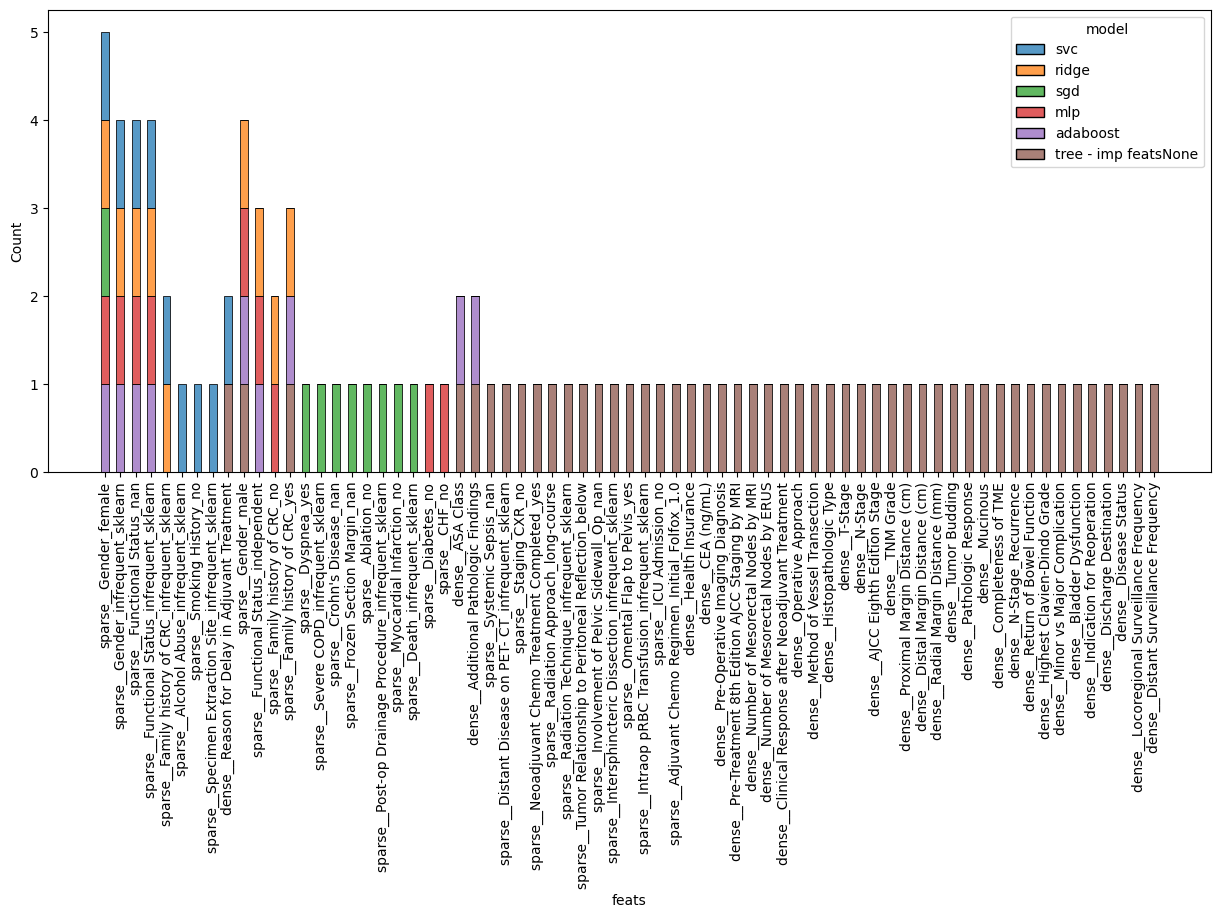

['Gender', 'Functional Status', 'Family history of CRC']


In [34]:
sankey = SankeyPlot()
sfs_feats = sankey.analyze_sfs(plot_data, leak_prepared, labels_train, model_dict, 
                           tree_model=AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=SEED),
                           agreement=3, direction='forward', n_features=10,
                           feature_parser=extract_original_feature, 
                           test=test_prepared, labels_test=labels_test,
                           save_path="./forward_n10_1715347011_sfs.json", load_only=True)
print(sfs_feats)

In [35]:
sfs_feats.append('Anastomotic Leak')
sankey.build_sankey(plot_data, sfs_feats, 'Anastomotic Leak', 
                    color_json='../Data Sources/Cleaned/feature_colors.json',
                    link_swatch = px.colors.qualitative.Pastel1_r,
                    hover_swatch = px.colors.qualitative.Set1_r)

In [28]:
plot_data = leak_mvp.copy()
plot_data['Anastomotic Leak'] = plot_data['Anastomotic Leak'].fillna('no')
# Group categories into treatment stages
stages = [
    ["Patient Demographics", "Patient Comorbidities", "Baseline Labs", "Diagnostic Work-Up", "Pre-Treatment Staging", "Neoadjuvant Treatment"],
    ["Post-Treatment Staging", "Operative Data", "Transfusion Data"],
    ["Histopathology", "Post-Operative Outcomes", "Adjuvant Treatment"],
    ["Follow-Up"]
]


/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



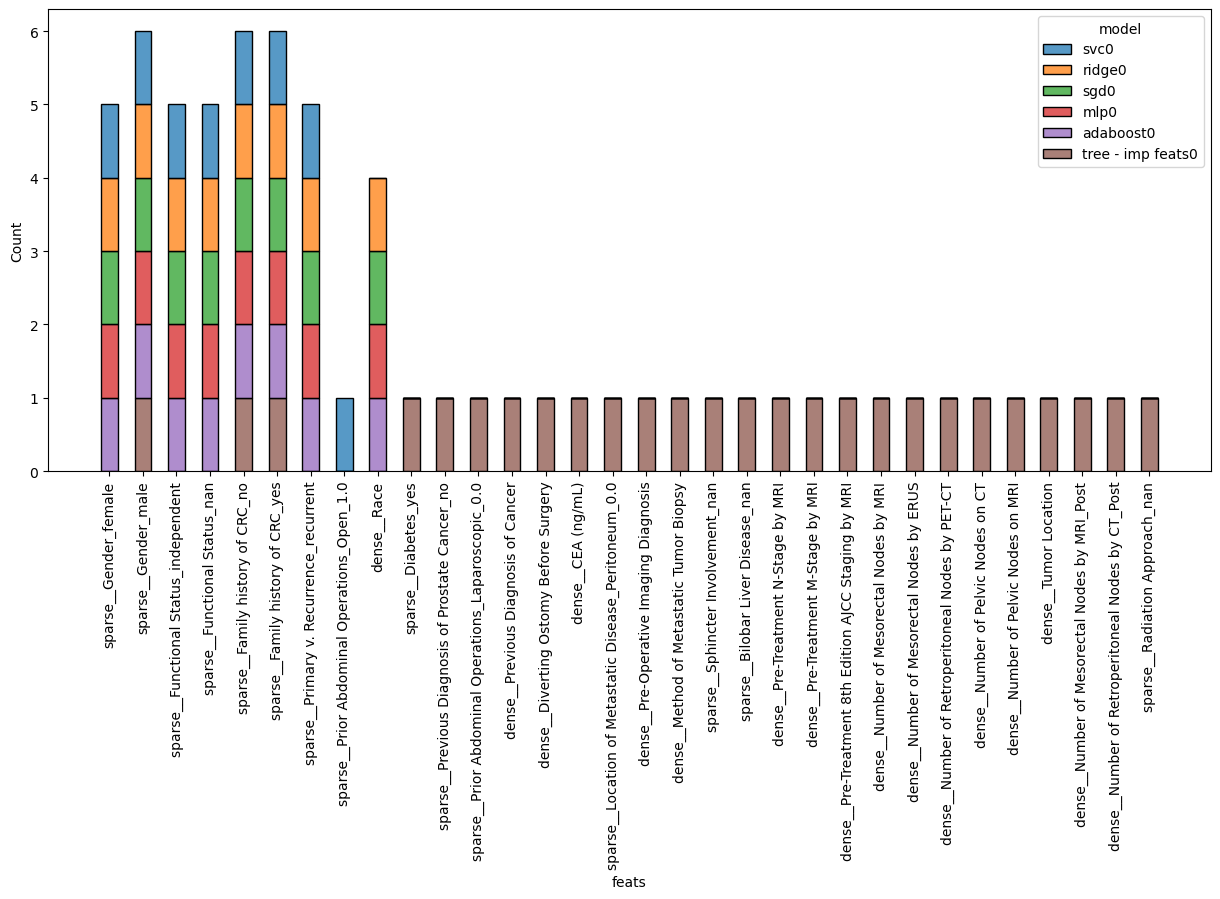

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



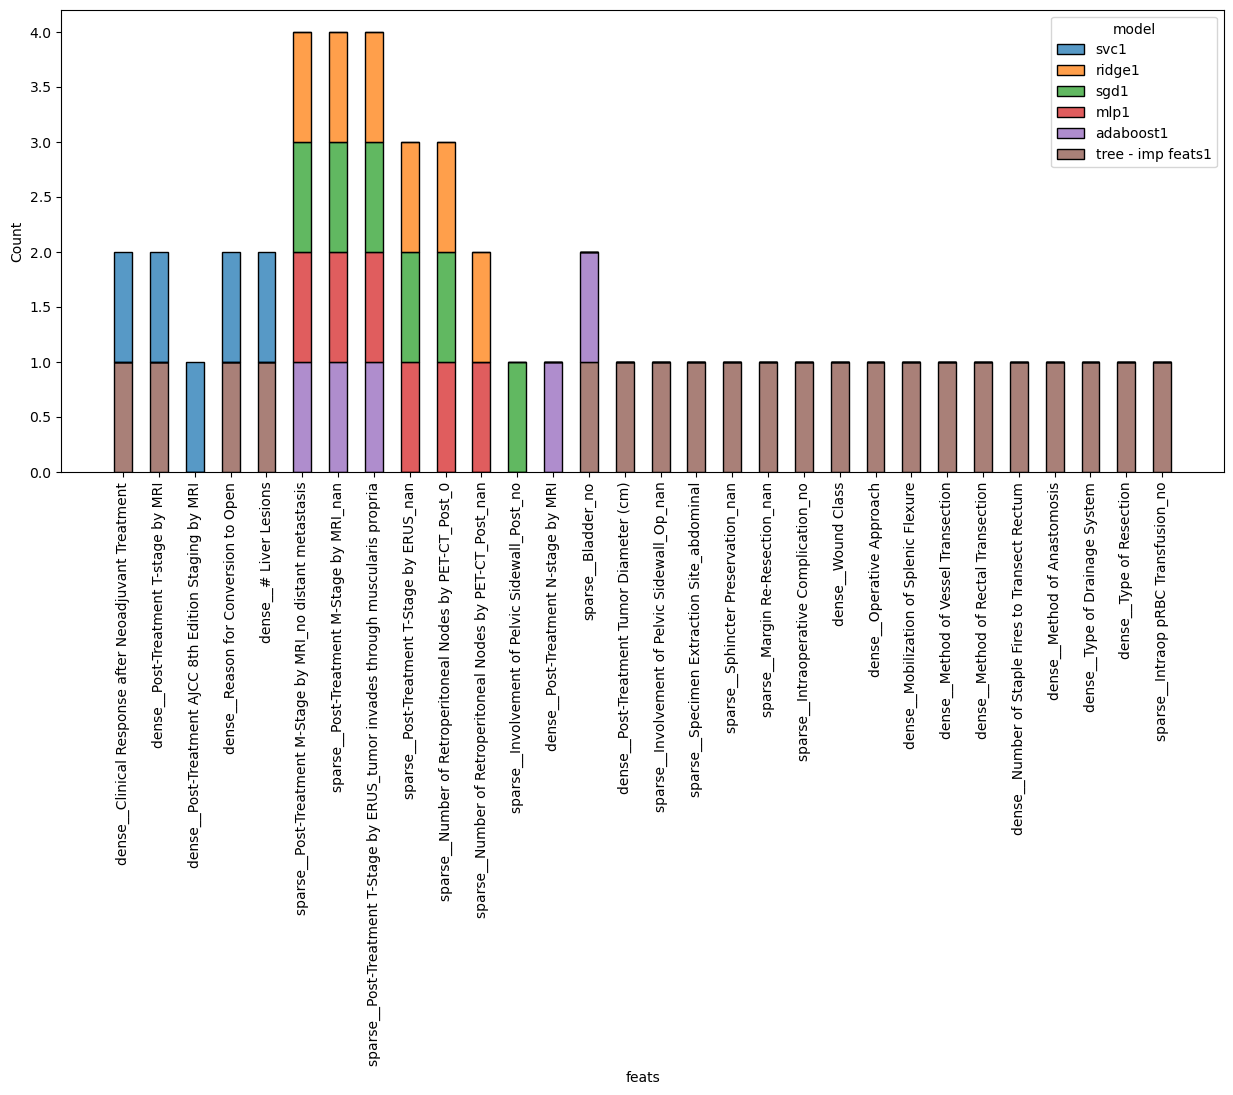

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



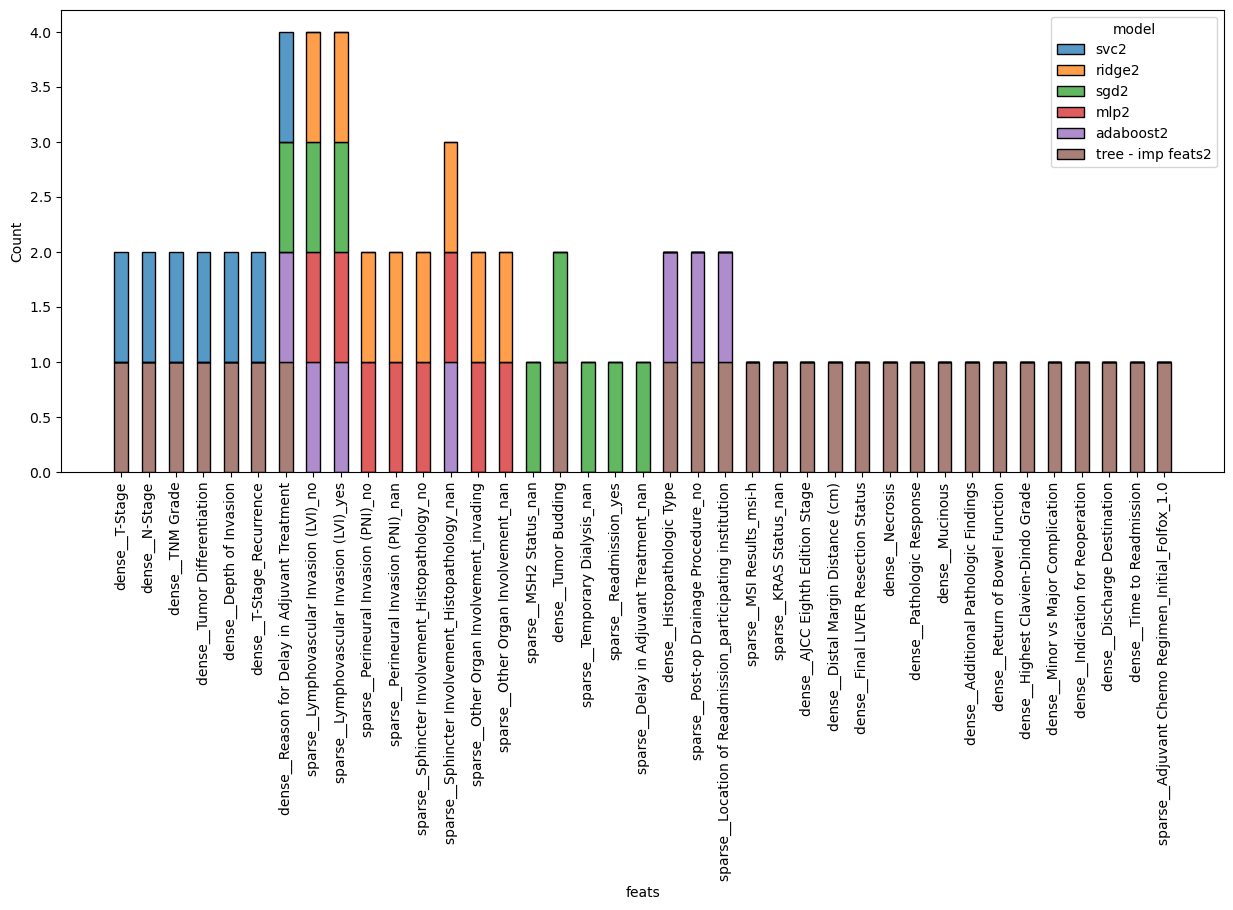

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



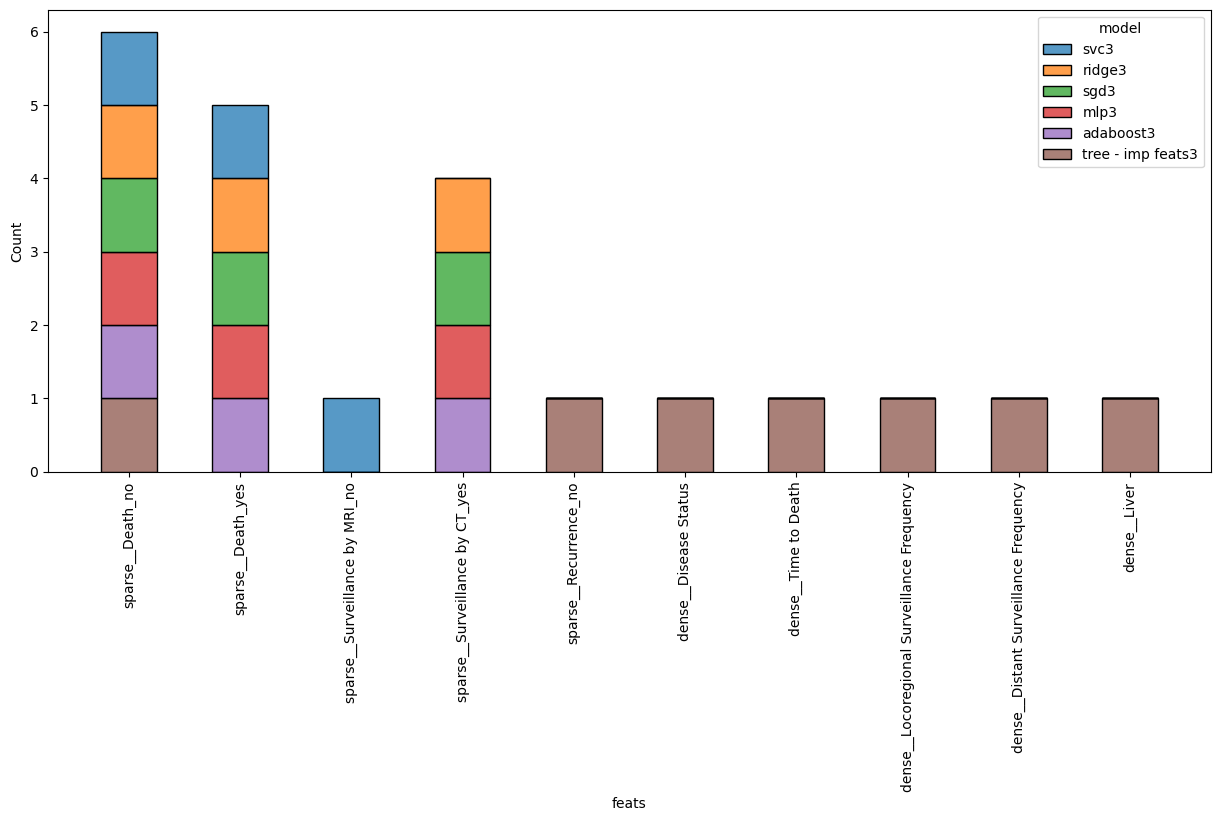

In [33]:
sankey = SankeyPlot()
model_dict = {
    "svc": svm.SVC(C=5, random_state=SEED),
    "ridge": linear_model.RidgeClassifierCV(),
    "sgd": linear_model.SGDClassifier(loss='log_loss'),
    "mlp": MLPClassifier(alpha=1, max_iter=1000, random_state=SEED),
    "adaboost": AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=SEED),
}

sankey.build_feature_chain(plot_data, leak_prepared, labels_train, model_dict,
                           enc_test=test_prepared, labels_test=labels_test, link_swatch = px.colors.qualitative.Pastel1_r,
                           tree_model=AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=SEED),
                           agreement=3, stages=stages, category_dict='../Data Sources/Cleaned/feature_categories.json',
                           response='Anastomotic Leak', direction='forward', n_features=0.05,
                           color_json='../Data Sources/Cleaned/feature_colors.json',
                           color_swatch = px.colors.qualitative.Pastel1_r,
                           hover_swatch = px.colors.qualitative.Set1_r,
                           feature_parser=extract_original_feature, load_sfs='./forward_n0.05_1715354265_sfs.json')

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



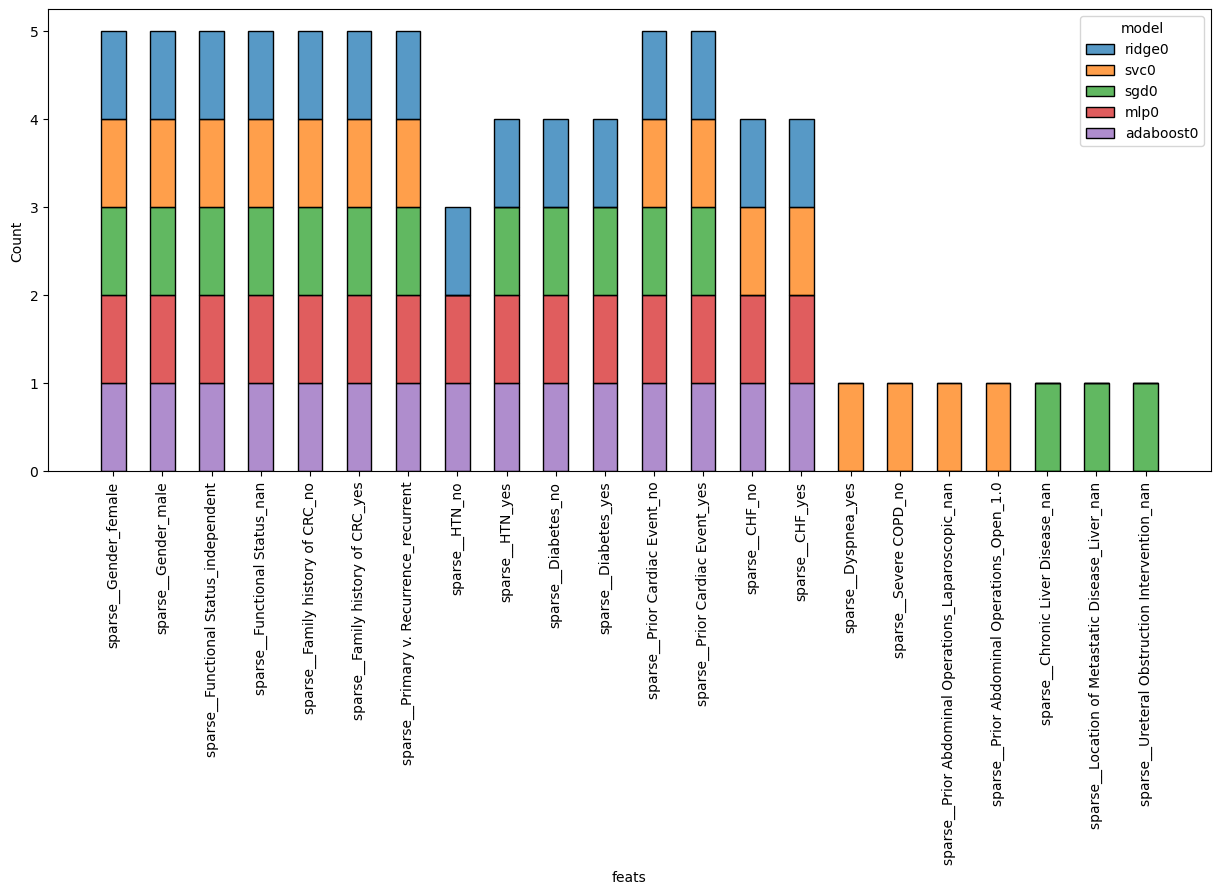

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



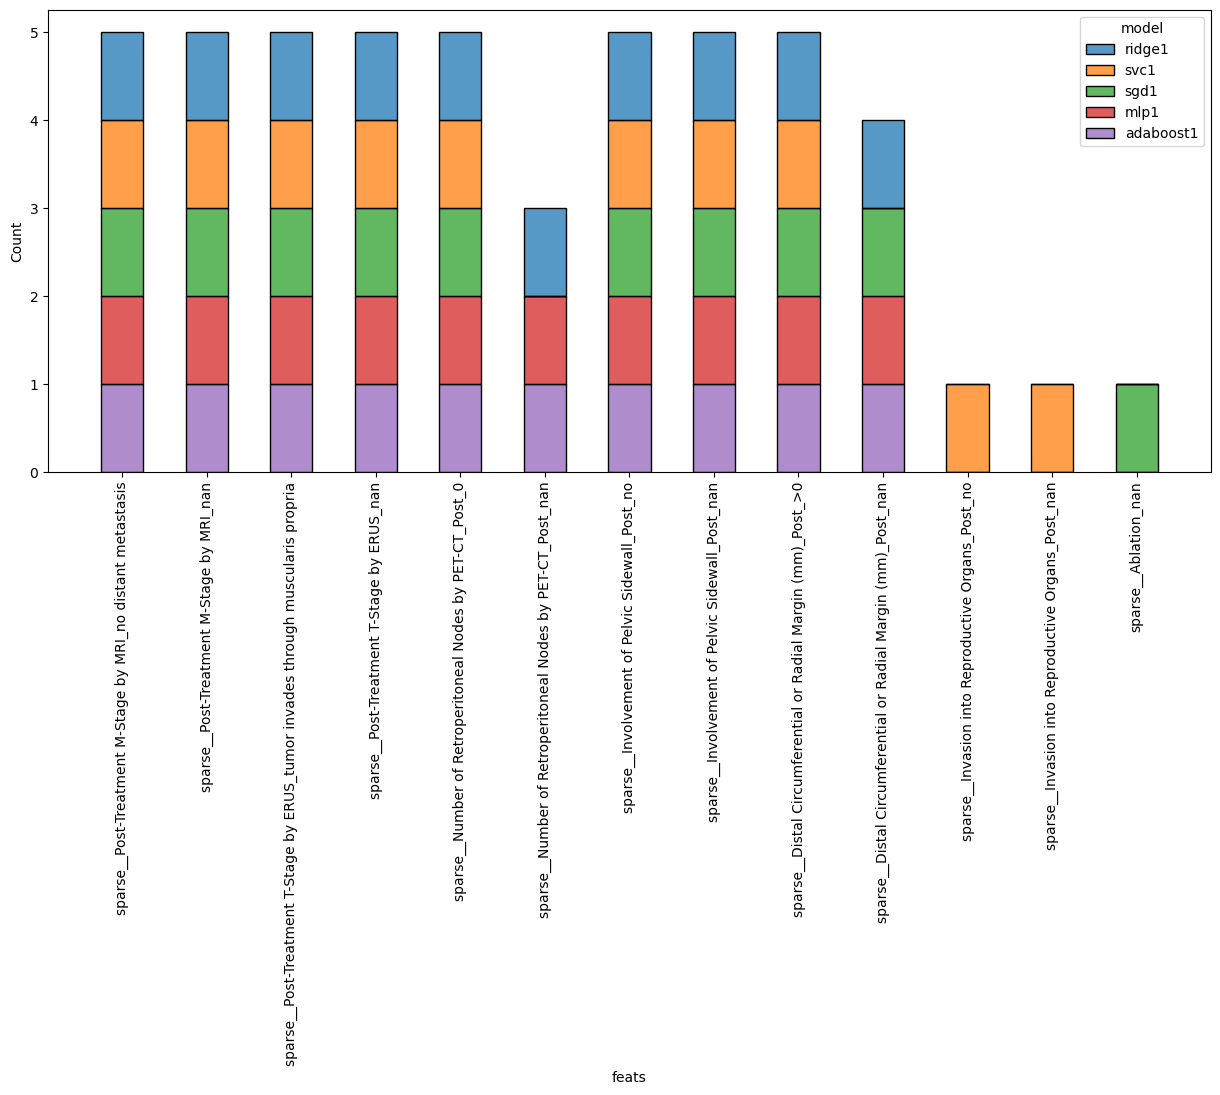

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



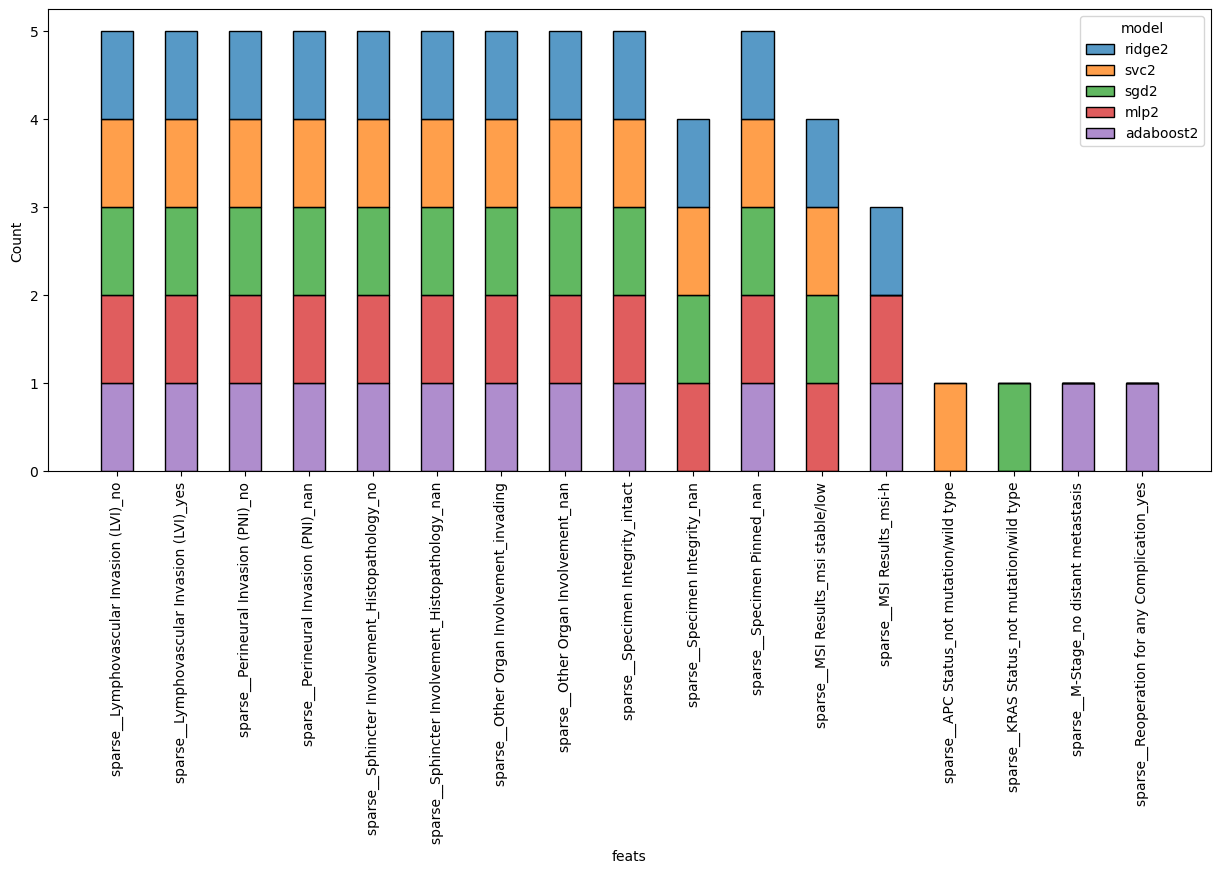

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



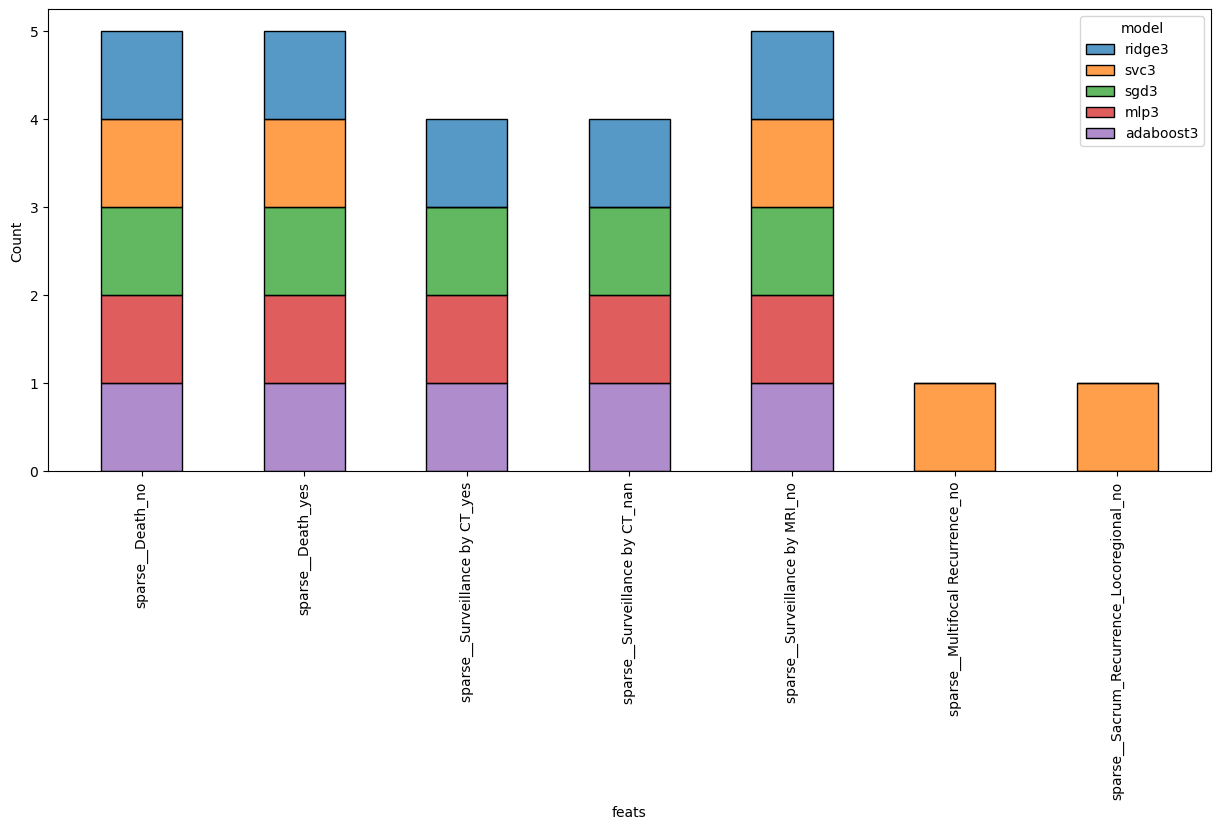

['rgb(153,153,153)', 'rgb(247,129,191)', 'rgb(166,86,40)', 'rgb(255,255,51)', 'rgb(255,127,0)', 'rgb(152,78,163)', 'rgb(77,175,74)', 'rgb(55,126,184)', 'rgb(228,26,28)']


In [24]:
sankey.build_feature_chain(plot_data, leak_prepared, labels_train, model_dict,
                           enc_test=test_prepared, labels_test=labels_test, 
                           tree_model=AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=SEED),
                           agreement=3, stages=stages, category_dict='../Data Sources/Cleaned/feature_categories.json',
                           response='Anastomotic Leak', direction='forward', n_features=0.1,
                           color_json='../Data Sources/Cleaned/feature_colors.json',
                           color_swatch = px.colors.qualitative.Pastel1_r,
                           hover_swatch = px.colors.qualitative.Set1_r,
                           feature_parser=extract_original_feature, load_sfs="./forward_n0.1_1712248823_sfs.json")

Done in 31.149s
Done in 78.261s
Done in 30.672s
Done in 903.451s
Done in 512.345s


/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



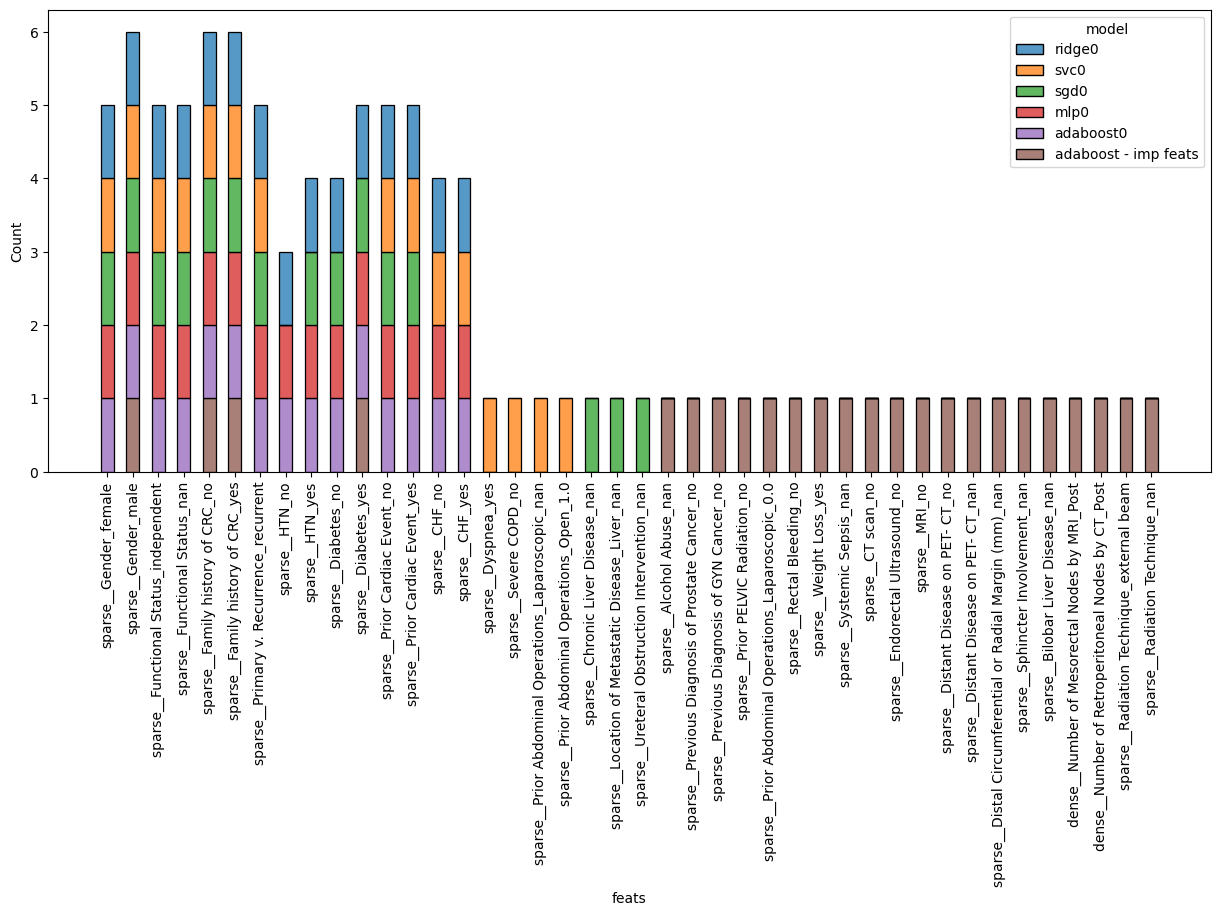

Done in 13.740s
Done in 38.154s
Done in 13.693s
Done in 302.139s
Done in 239.186s


/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



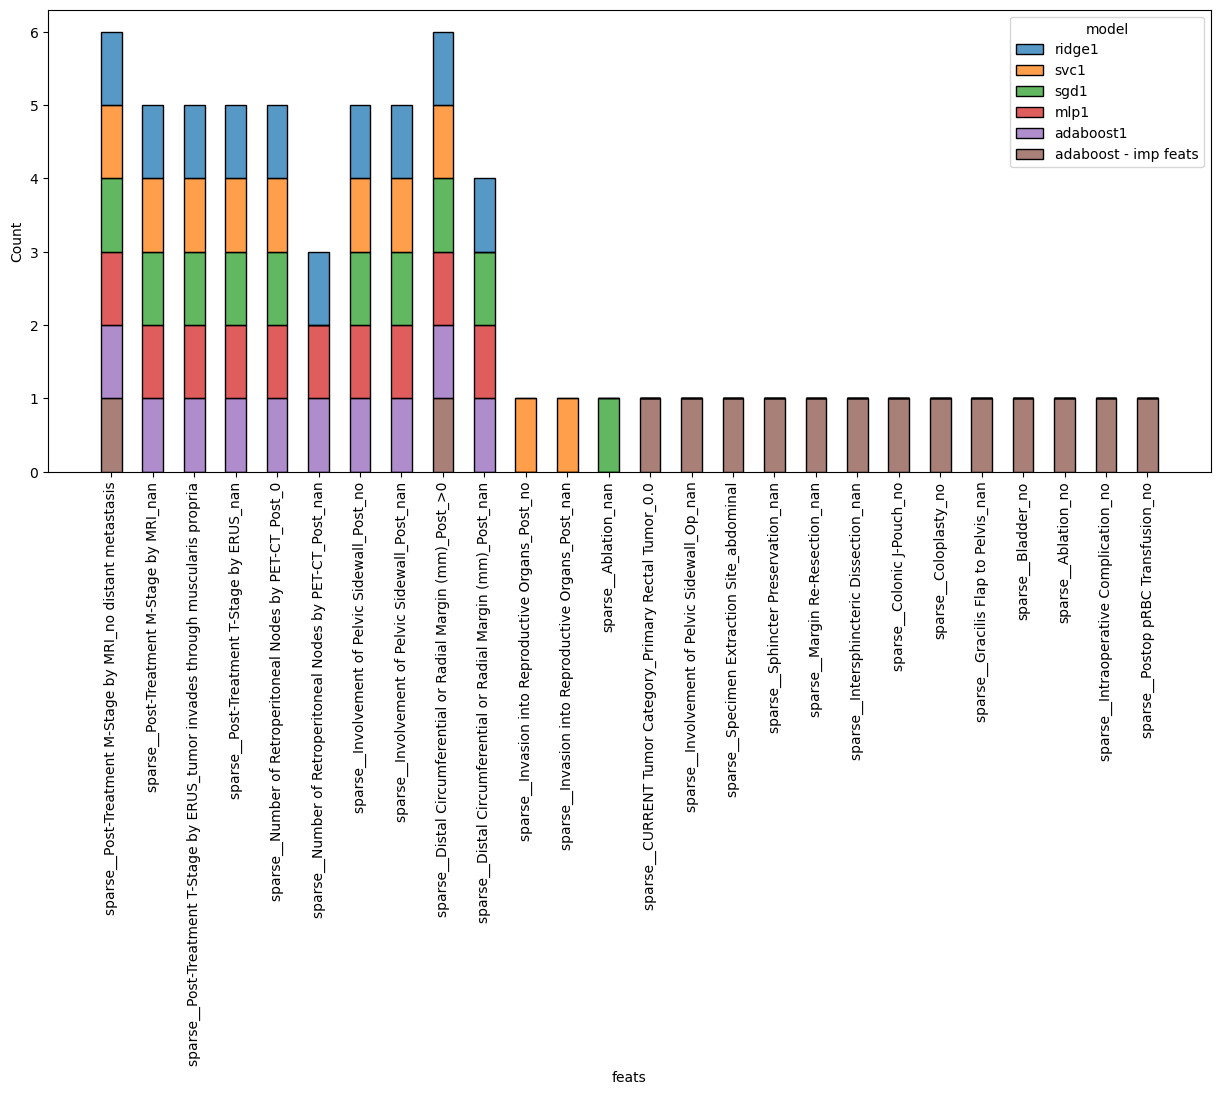

Done in 20.546s
Done in 51.549s
Done in 22.181s
Done in 628.280s
Done in 362.037s


/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



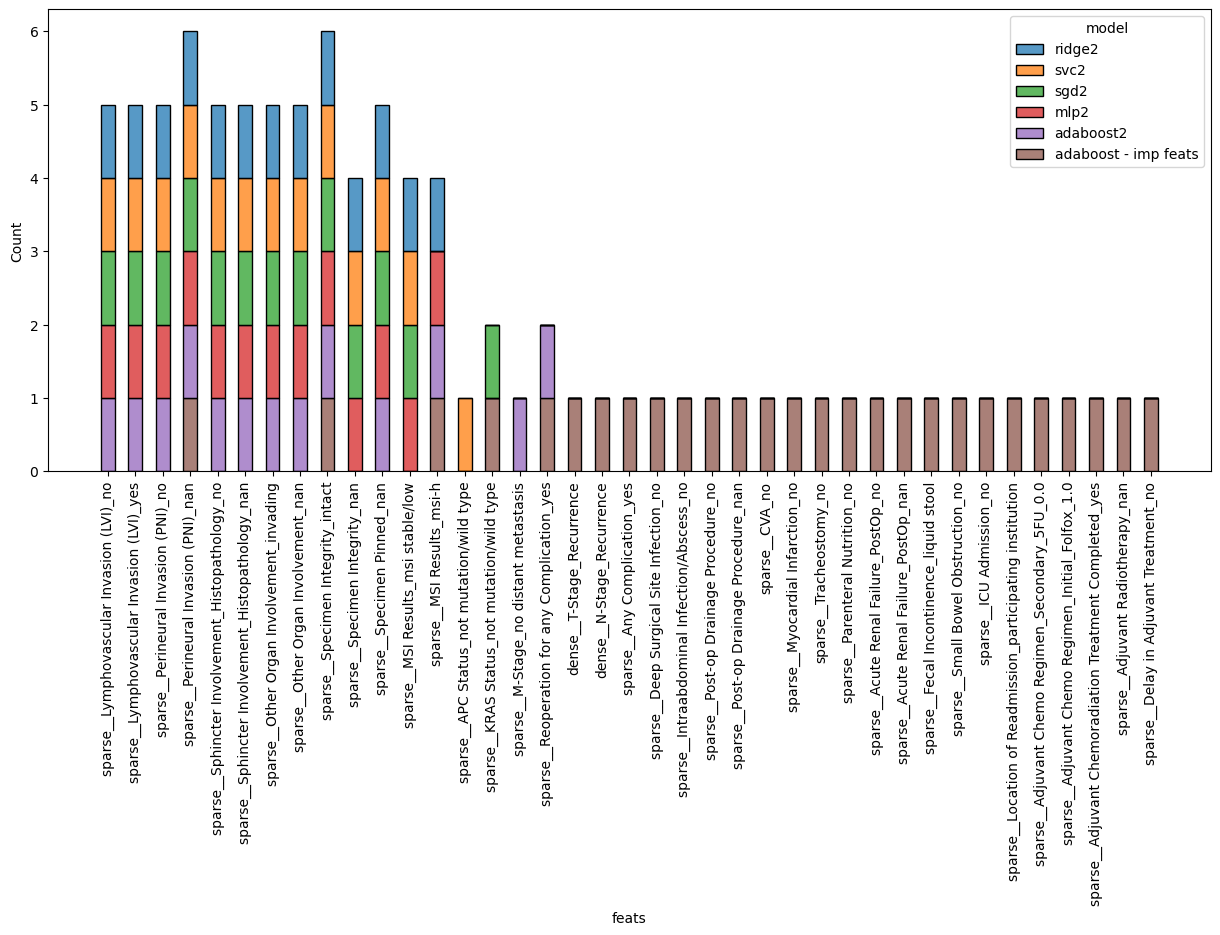

Done in 3.430s
Done in 8.471s
Done in 3.481s
Done in 62.414s
Done in 59.884s


/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



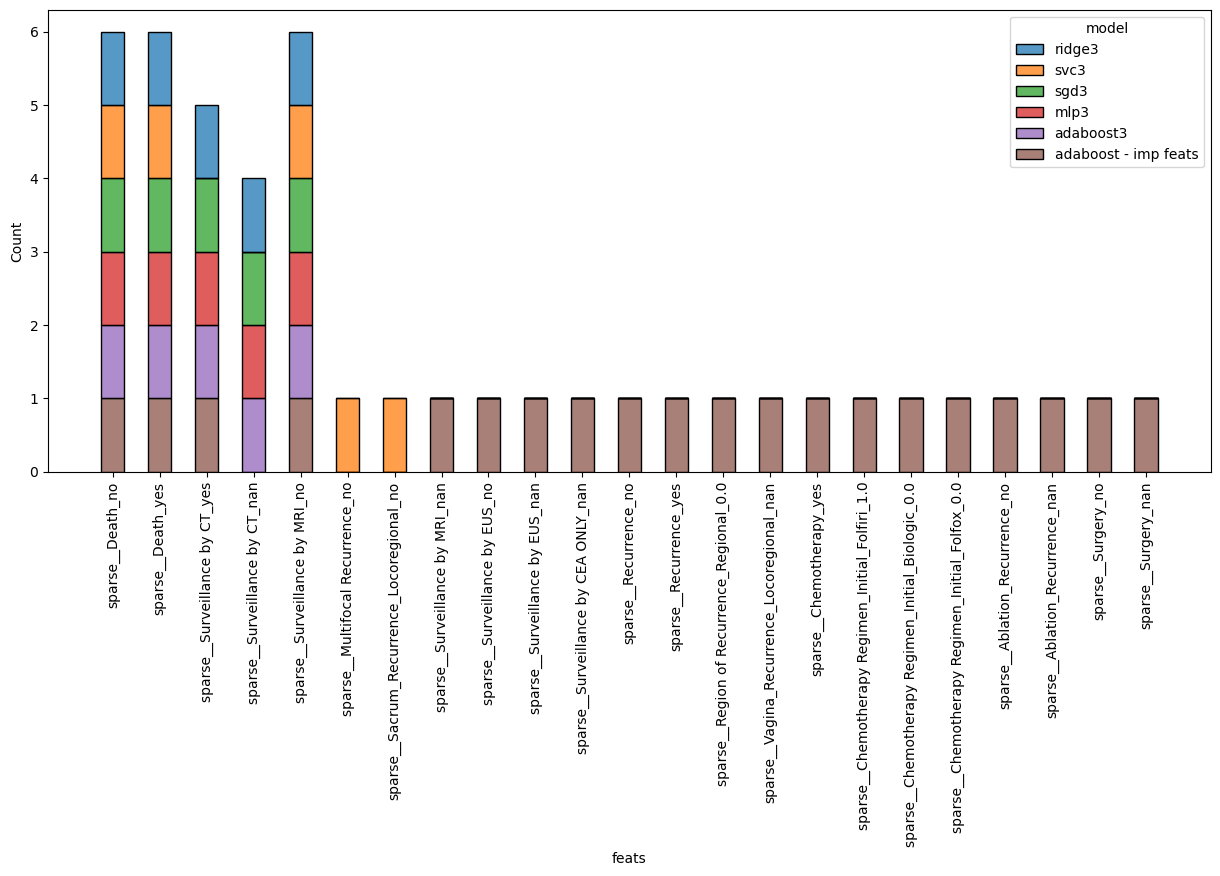

In [51]:
build_feature_chain(plot_data, leak_prepared, labels_train, test_prepared, labels_test,
                    agreement=3, response='Anastomotic Leak', direction='forward', n_features=0.1)

Done in 217.877s
Done in 381.193s
Done in 184.371s
Done in 12696.348s
Done in 2890.701s


/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



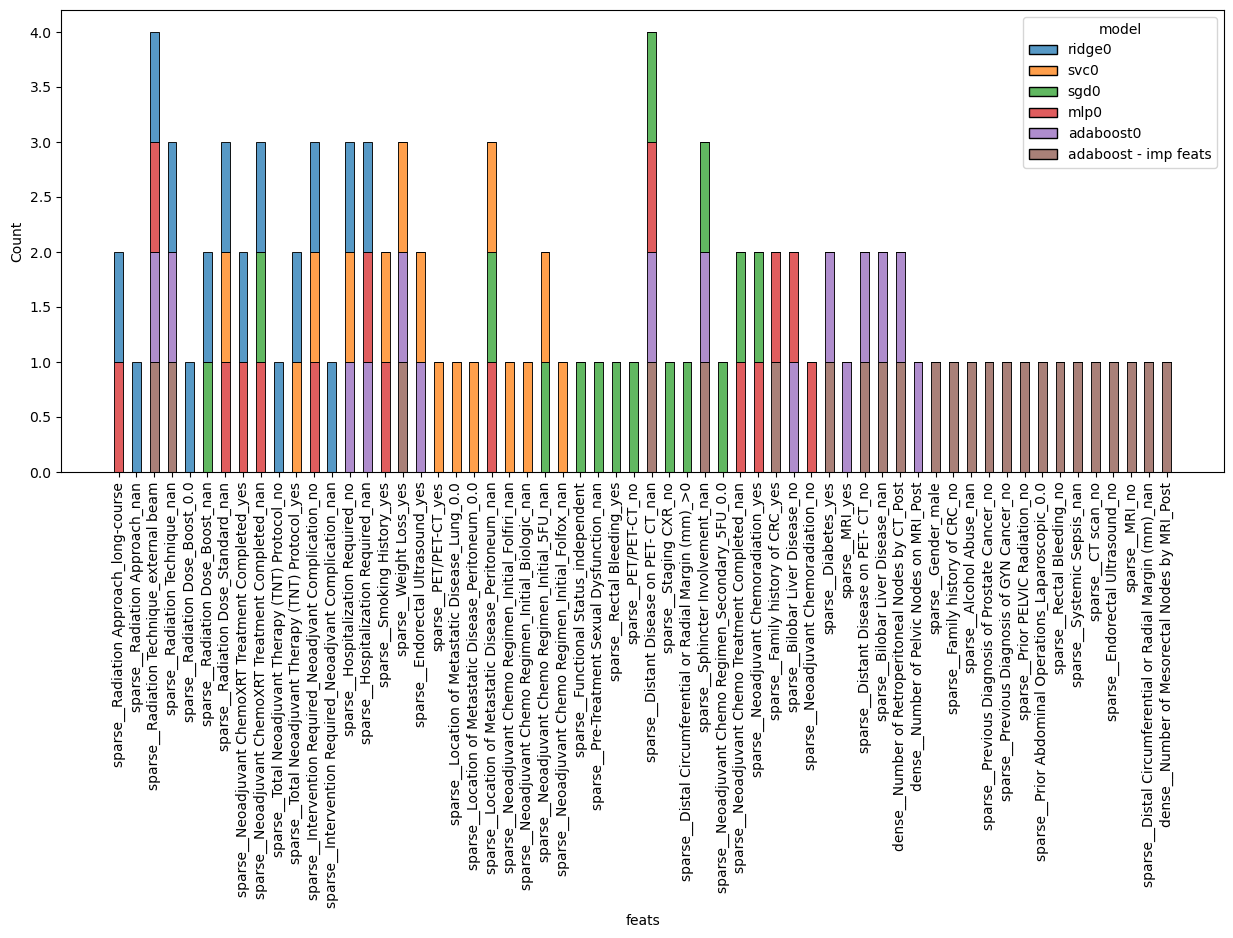

Done in 86.527s
Done in 186.056s
Done in 87.154s
Done in 5038.573s
Done in 1423.842s


/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



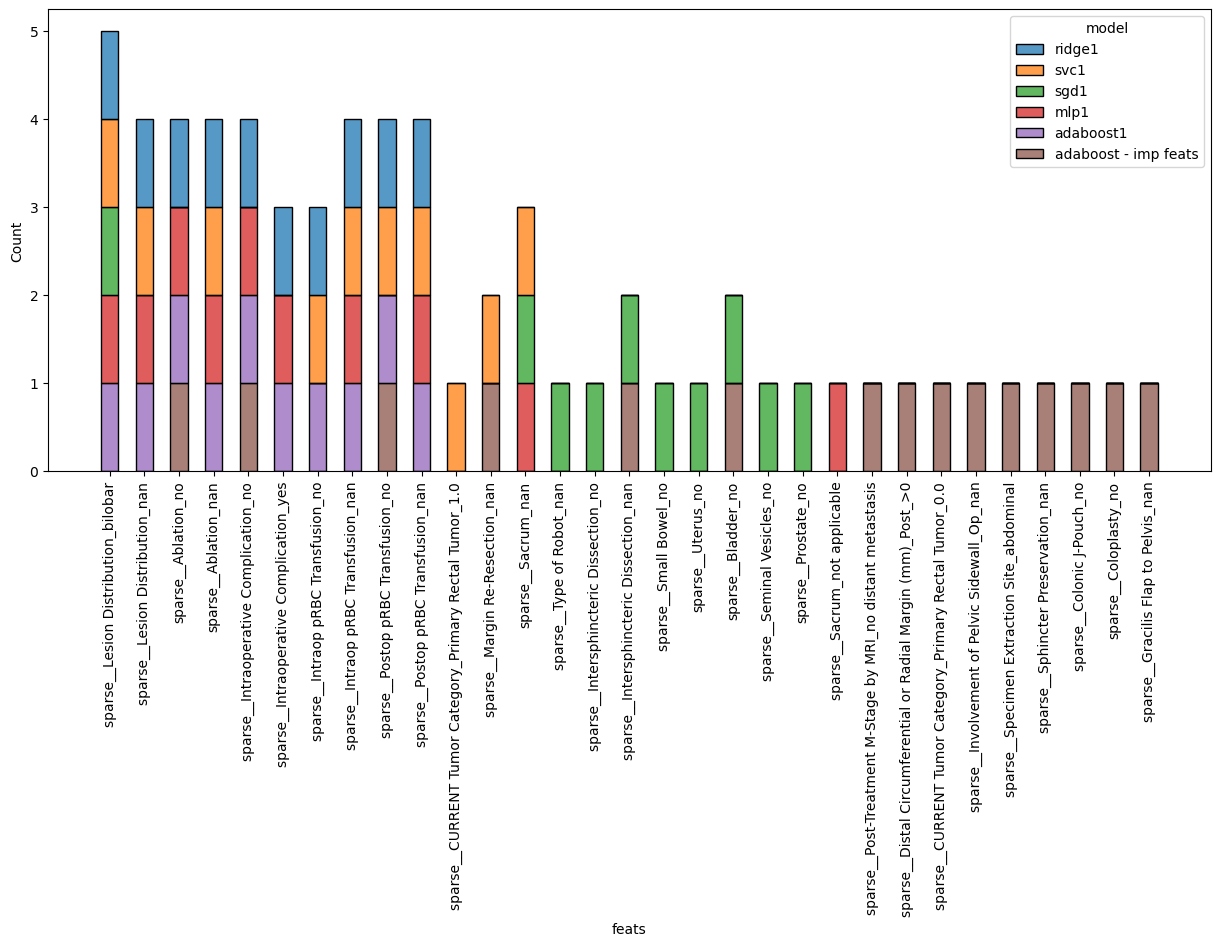

Done in 157.178s
Done in 298.957s
Done in 150.902s
Done in 8683.244s
Done in 2157.379s


/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



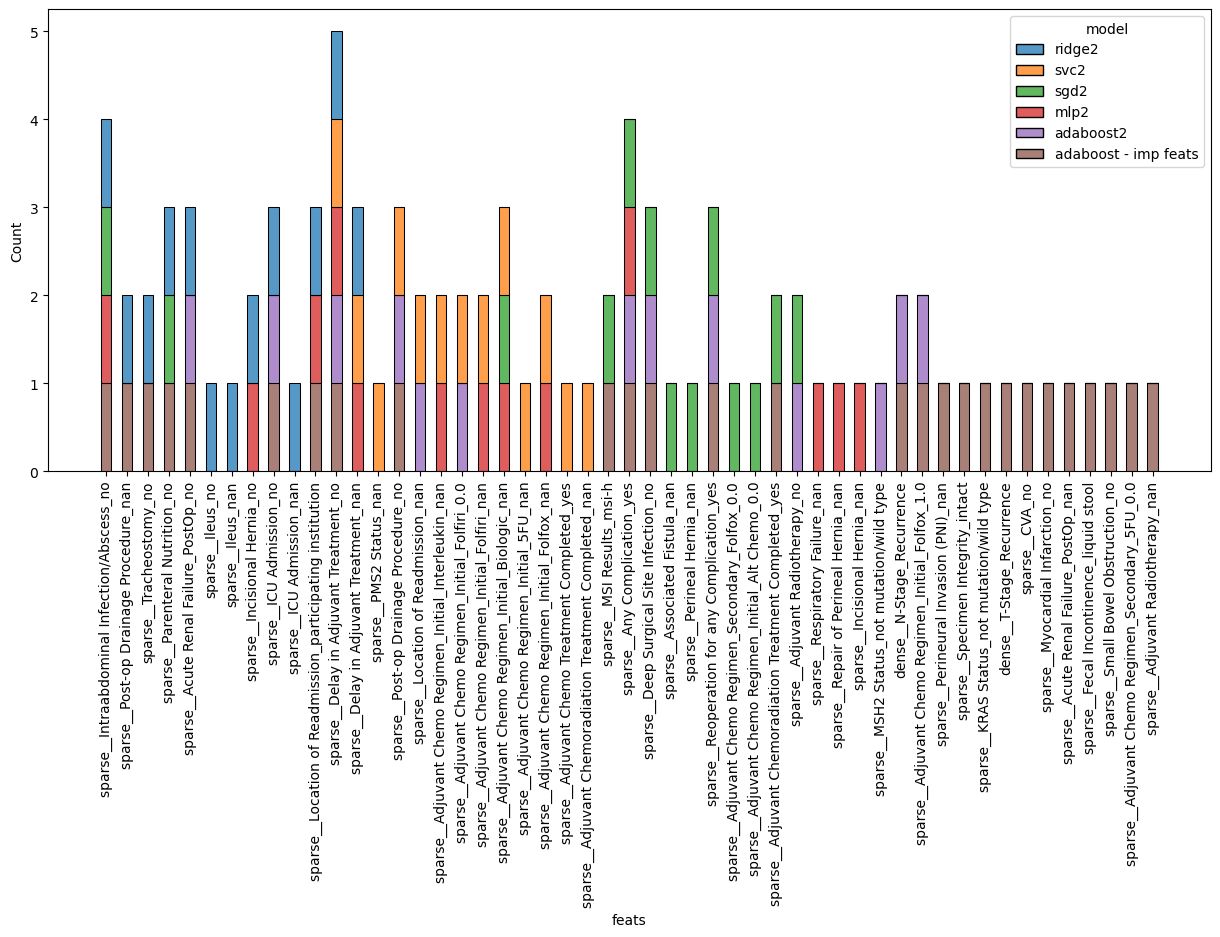

Done in 25.554s
Done in 50.951s
Done in 26.369s
Done in 1157.441s
Done in 351.243s


/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



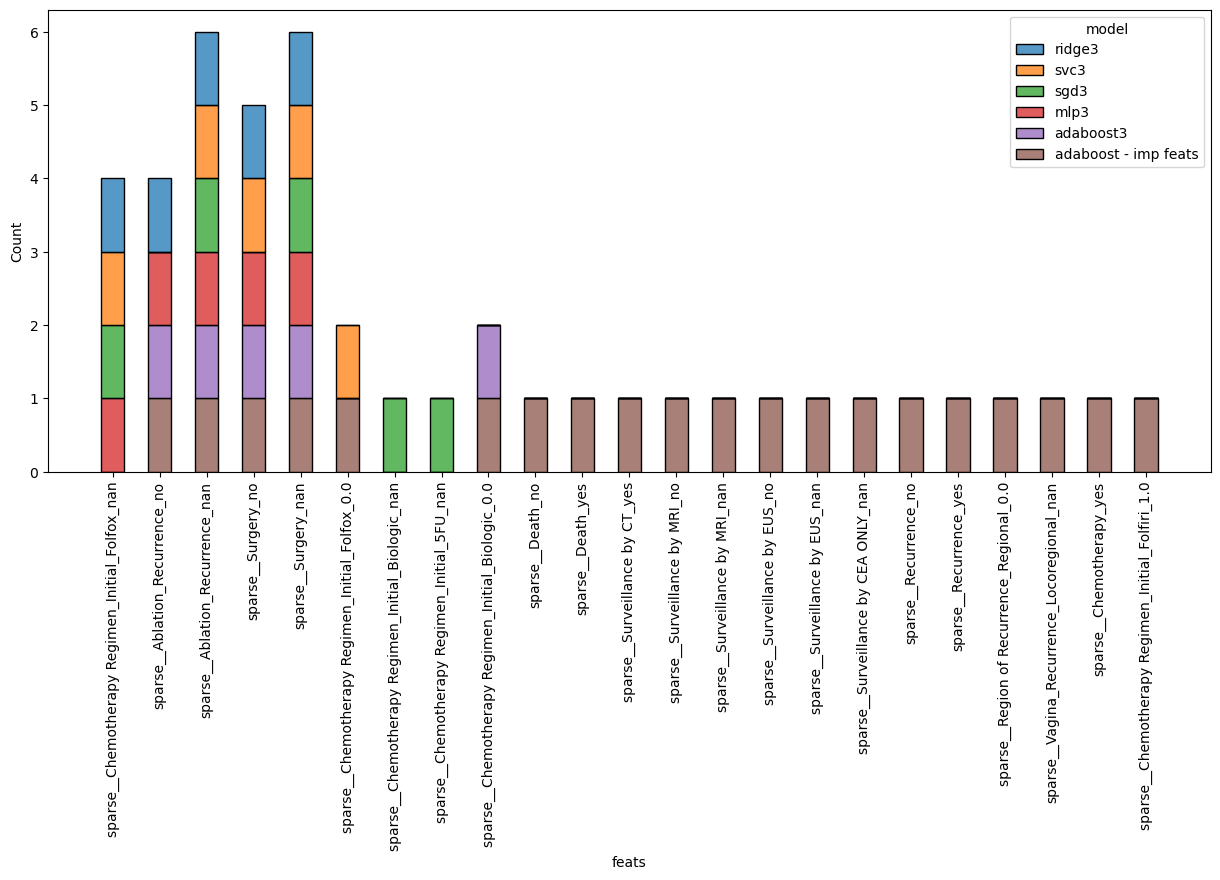

In [25]:
build_feature_chain(plot_data, leak_prepared, labels_train, test_prepared, labels_test,
                    agreement=3, response='Anastomotic Leak', direction='backward', n_features=0.1)

## TODO: Incorporating Patient Information
Taking this same model, lets assume that we're a team of clinicians trying to make a treatment decision. This implies that we are at a particular stage in treatment, and only know information about the patient up to that stage. We can filter the dataset for similar observations and visualize their flow to a desired outcome, focusing only on the most important variables/decisions. 

## Visualizing Outcome-Related Features

TODO: Reimplement using sankey class

Separately from trying to predict a particular outcome, we can use the diagram to see how treatment stage-specific outcomes flow into each other.

In [47]:
feats = [
        # Demos
        'Family history of CRC',
        # Comorbs
        'Prior Abdominal Operations_Laparoscopic',
        'Prior Abdominal Operations_Open',
        # Diagnostic
        'Metastatic Disease',
        # Pre T
        'Pre-Treatment 8th Edition AJCC Staging by MRI',
        # Neoadj
        'Total Neoadjuvant Therapy (TNT) Protocol',
        # Post T
        'Clinical Response after Neoadjuvant Treatment',
        # Op
        'Intraoperative Complication',
        # Trans
        'Postop pRBC Transfusion',
        # Histopath
        'Pathologic Response',
        # Post-op
        'Readmission',
        # Adj
        'Adjuvant Chemo Treatment Completed',
        'Adjuvant Chemoradiation Treatment Completed',
        # Follow-up
        'Disease Status',
        ]

response = 'Disease Status'
sankey_from_cleaned_data(leak_mvp, feats, response)

## Reproduce statistical tests

### OFP -> Leak

In [ ]:
contingency_tab = pd.crosstab(leak_mvp['Omental Flap to Pelvis'], leak_mvp['Anastomotic Leak'], margins=False, dropna=False)
contingency_tab

Anastomotic Leak         no  yes  NaN
Omental Flap to Pelvis               
no                      372   32  318
yes                      74    9   20

In [ ]:
scipy.stats.chi2_contingency(contingency_tab)

Chi2ContingencyResult(statistic=23.591827257150264, pvalue=7.535287068704235e-06, dof=2, expected_freq=array([[390.31757576,  35.88121212, 295.80121212],
       [ 55.68242424,   5.11878788,  42.19878788]]))

In [ ]:
imp_leak = leak_mvp['Anastomotic Leak'].fillna('no')
contingency_tab = pd.crosstab(leak_mvp['Omental Flap to Pelvis'], imp_leak, margins=False, dropna=False)
contingency_tab

Anastomotic Leak         no  yes
Omental Flap to Pelvis          
no                      690   32
yes                      94    9

In [ ]:
scipy.stats.chi2_contingency(contingency_tab)

Chi2ContingencyResult(statistic=2.685544408776171, pvalue=0.10126261252919086, dof=1, expected_freq=array([[686.11878788,  35.88121212],
       [ 97.88121212,   5.11878788]]))

#### Results

We could not replicate the p-value of 0.618 from Ali et. al. (2024). This is due in part to dropping samples perceived as dirty in ```Data Cleaning/cleaning.ipynb```. Indeed, when these samples are (mostly) included, the p-value increases to a max of 0.2 in the imputed case. The additional margin could be a result of using simple imputation (NaN -> no leak) instead of MICE.

# Explore Suggested Relationships

TODO: Reimplement to use Sankey class

Glen suggested that I look into the relationship of distance from anal verge on leakage, since is generally thought that smaller distance from anal verge (< 5 cm) means greater chance of a leak. 

In [57]:
# Include only those with LAR and non-empty
lar_df = rcc[(rcc['Type of Operation of Rectal Tumor'] == 'lar')].copy()
lar_df['Anastomotic Leak'] = lar_df['Anastomotic Leak'].fillna('no')

# Encode 'Anastomosis Distance from Anal Verge' into less than and greater than 5 cm
lar_df['Anastomosis Distance from Anal Verge (cm)'] = pd.cut(lar_df['Anastomosis Distance from Anal Verge (cm)'], [0.0, 5.0, 12.0], 
                                                             labels = ['<5', '>=5'], right=False, include_lowest=True)

# Viz with sankey, together with intervention and sepsis features
feats = ['Anastomosis Distance from Anal Verge (cm)', 'Diverting Loop Ileostomy', 'Intervention Required', 'Minor vs Major Complication', 'Deep Surgical Site Infection', 'Intraabdominal Infection/Abscess', 'Anastomotic Leak']
sankey_from_cleaned_data(lar_df, feats, 'Anastomotic Leak')

With most nan's as 'no'-equivalent:

In [58]:
lar_df['Diverting Loop Ileostomy'] = lar_df['Diverting Loop Ileostomy'].fillna('no')
lar_df['Intervention Required'] = lar_df['Intervention Required'].fillna('no')
lar_df['Minor vs Major Complication'] = lar_df['Minor vs Major Complication'].fillna('no complication')
lar_df['Deep Surgical Site Infection'] = lar_df['Deep Surgical Site Infection'].fillna('no')
lar_df['Intraabdominal Infection/Abscess'] = lar_df['Intraabdominal Infection/Abscess'].fillna('no')

sankey_from_cleaned_data(lar_df, feats, 'Anastomotic Leak')

With encoded data:

In [ ]:
def sankey_from_encoded_data(data: pd.DataFrame, feats: list, response: str, vertical_pad=15):
    labels = []
    sources = []
    targets = []
    values = []
    x_pos = []
    y_pos = []
    p_values = []
    link_colors = []
    link_labels = []
    hover_colors = []

    response_vals = list(data[response].value_counts(dropna=False).sort_values(ascending=False).index)
    # NOTE: Only 8 values in this swatch, choose one with more levels if needed by response
    color_swatch = px.colors.qualitative.Pastel1_r
    hover_swatch = px.colors.qualitative.Set1_r

    val_counts = []
    x_reference = np.linspace(0.0, 1.0, num=len(feats)).tolist()
    for i, feat in enumerate(feats):
        val_counts.append(data[feat].value_counts(dropna=False).sort_values(ascending=False))
        unique_vals = list(val_counts[i].index)
        labels.extend([feat + ': ' + str(val) for val in unique_vals])
        x_pos.extend(np.full(len(unique_vals), x_reference[i]))
        # Accurately calculate y-position between 0 and 1
        level_counts = val_counts[i].to_list()
        level_props = [count / sum(level_counts) for count in level_counts]
        y_align = [1 - (sum(level_props[:i]) + (val / 2)) for i, val in enumerate(level_props)]
        # Reverse list
        y_pos.extend(y_align[::-1])
        # Do chi^2 tests
        if (feat != response):
            contingency_tab = pd.crosstab(data[feat], data[response], margins=False, dropna=False)
            x2_res = scipy.stats.chi2_contingency(contingency_tab)
            p_values.append(x2_res.pvalue)
        if (i > 0):
            prior_unique_vals = list(val_counts[i - 1].index)
            for j, value in enumerate(unique_vals):
                for k, prior_value in enumerate(prior_unique_vals):
                    for x, response_value in enumerate(response_vals):
                        # Count num samples with both values
                        if pd.isnull(value): 
                            value_mask = data[feat].isna()
                        else: value_mask = data[feat] == value
                        
                        if pd.isnull(prior_value): 
                            prior_value_mask = data[feats[i-1]].isna()
                        else: prior_value_mask = data[feats[i-1]] == prior_value

                        if pd.isnull(response_value): 
                            response_value_mask = data[response].isna()
                        else: response_value_mask = data[response] == response_value

                        values.append(len(data[(value_mask) & (prior_value_mask) & (response_value_mask)]) / len(data))
                        # Set source: index labels by -1 * (len(val_counts) + len(prior_val_counts) - k)
                        sources.append(labels.index(labels[-1 * (len(unique_vals) + len(prior_unique_vals) - k)]))
                        # Set target: index labels by -1 * (len(val_counts) - j)
                        targets.append(labels.index(labels[-1 * (len(unique_vals) - j)]))
                        link_colors.append(color_swatch[x])
                        link_labels.append(response + ": " + str(response_value))
                        hover_colors.append(hover_swatch[x])
    
    # Create sankey/alluvial diagram
    # Load color dict
    with open('../Data Sources/Cleaned/feature_colors.json') as fp:
        color_dict = json.load(fp)

    # Get the proper keys for each entry
    # BUG: Will only select the first instance in keys that is a substring of label, not the best possible match
    # Ex) Given sparse_Prostate, will select Previous Diagnosis of Prostate Cancer instead of Prostate
    colors = []
    for label in labels[:-len(response_vals)]:
        for key, value in color_dict.items():
            if (key in label):
                colors.append(value)
                break
    colors.extend(hover_swatch[:len(response_vals)])

    fig = go.Figure(data=[go.Sankey(
        arrangement='snap',
        valueformat = ".2%",
        node = dict(
            pad = vertical_pad,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = labels,
            color = colors,
            x = x_pos,
            y = y_pos,
        ),
        link = dict(
            source = sources, # indices correspond to labels
            target = targets,
            value = values,
            label = link_labels,
            color = link_colors,
            # BUG: In Plotly package, does not update colors
            hovercolor = hover_colors,
        ))])

    # Add chi^2 p-vals as annotations
    # NOTE: Assumes response is last (x_reference[-1])
    for i, p in enumerate(p_values):
        fig.add_annotation(
            text = "p-value: {:.3e}".format(p),
            x = x_reference[i],
            y = 0,
            yshift = -75,
            showarrow = False,
        )

    fig.update_layout(title_text="Sankey Diagram of Encoded Data: {}".format(response), font_size=10, height=500, width=300 * len(feats))
    fig.show()

In [ ]:
plot_data = leak_prepared.copy()
plot_data['Anastomotic Leak'] = labels_train.to_list()
imp_enc_feats = imp_feats.copy()
imp_enc_feats.append('Anastomotic Leak')
sankey_from_encoded_data(plot_data, imp_enc_feats, 'Anastomotic Leak')